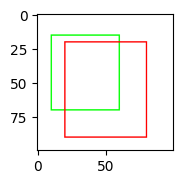

Площадь пересечения: 2000
Площадь обьединения: 4950
IoU: 0.40404040404040403
IoU Loss: 0.595959595959596


In [1]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

#посмотрим алгортм расчета пересечения и обьединения

def intersection_area(minx1, miny1, maxx1, maxy1, minx2, miny2, maxx2, maxy2):
    # Пересечение по оси X
    x_overlap = max(0, min(maxx1, maxx2) - max(minx1, minx2))
    # Пересечение по оси Y
    y_overlap = max(0, min(maxy1, maxy2) - max(miny1, miny2))
    
    if x_overlap == 0 or y_overlap == 0:
        return 0.0
    # Считаем площадь
    area = x_overlap * y_overlap
    return area

def union_area(minx1, miny1, maxx1, maxy1, minx2, miny2, maxx2, maxy2):
    # Посчитаем просто площади
    area1 = (maxx1 - minx1) * (maxy1 - miny1)
    area2 = (maxx2 - minx2) * (maxy2 - miny2)
    
    # Пересечение
    intersection = intersection_area(minx1, miny1, maxx1, maxy1, minx2, miny2, maxx2, maxy2)
    
    # Вычтем пересечение из суммы площадей
    union_area = area1 + area2 - intersection
    return union_area

#посмотрим как это работает
screen = np.full((100,100,3), 255, dtype=np.float32)

minx1, miny1, maxx1, maxy1 = 10, 15, 60, 70
minx2, miny2, maxx2, maxy2 = 20, 20, 80, 90

screen = cv2.rectangle(screen ,(minx1, miny1 ),(maxx1, maxy1),(0,255,0),1)
screen = cv2.rectangle(screen ,(minx2, miny2 ),(maxx2, maxy2),(255,0,0),1)
screen/=255
#выводим
plt.figure(figsize=(10, 6))
ax = plt.subplot(3, 1, 1)
plt.imshow(screen)
plt.show()

intersection_area_result = intersection_area(minx1, miny1, maxx1, maxy1, minx2, miny2, maxx2, maxy2)
union_area_result = union_area(minx1, miny1, maxx1, maxy1, minx2, miny2, maxx2, maxy2)
print("Площадь пересечения:", intersection_area_result)
print("Площадь обьединения:", union_area_result)
IoU = intersection_area_result/union_area_result
print('IoU:', IoU)
print('IoU Loss:', 1- IoU)

In [2]:
#импортируем разное
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)
from os import listdir
from os.path import isfile, join
import matplotlib.pyplot as plt
import numpy as np
import cv2

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


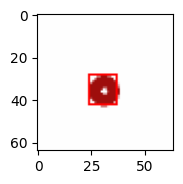

[[24 28 37 42]]


In [3]:
#прочитаем запись
dataset = tf.data.TFRecordDataset('bounding_box_dataset.tfrecord')


def parse_record(record):
    #нужно описать приходящий экземпляр
    #имена элементов как при записи
    feature_description = {
        'img': tf.io.FixedLenFeature([], tf.string),
        'cords': tf.io.FixedLenFeature([], tf.string)
    }
    parsed_record = tf.io.parse_single_example(record, feature_description)
    img = tf.io.parse_tensor(parsed_record['img'], out_type=tf.float32)
    cords = tf.io.parse_tensor(parsed_record['cords'], out_type=tf.float32)
    return img, cords

#пройдемся по записи и распакуем ее
dataset = dataset.map(parse_record)

#еще раз проверим
for i, c in dataset.take(1):
    plt.figure(figsize=(10, 6))
    ax = plt.subplot(3, 1, 1)
    i = i.numpy()
    c = c.numpy()
    c = (c+1)/2*64 #обратно из от -1...1 к 0...64
    c = c.astype(np.int16)  #для opencv
    for bb in c:
        i = cv2.rectangle(i ,(bb[0] ,bb[1] ),(bb[2], bb[3]),(1,0,0),1)
    plt.imshow(i)
    plt.show()
    print(c)
    
dataset = dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE).batch(32).shuffle(50)

In [10]:
from tensorflow import keras
from tensorflow.keras.layers import Dense, Flatten, Input, Conv2D, Conv2DTranspose, Concatenate, LeakyReLU, Dropout

#давайте напишем нейросеть

inputs = Input((64,64,3))
x = Conv2D(32, 3, activation = 'relu', padding = 'same')(inputs)
x = Conv2D(64, 3, activation = 'relu', padding = 'same', strides = 2)(x)
x = Conv2D(64, 3, activation = 'relu', padding = 'same')(x)
x = Conv2D(128, 3, activation = 'relu', padding = 'same', strides = 2)(x)
x = Conv2D(128, 3, activation = 'relu', padding = 'same')(x)
x = Conv2D(128, 3, activation = 'relu', padding = 'same', strides = 2)(x)

x = Flatten()(x)
x = Dropout(0.2)(x)
x = Dense(128, activation = 'relu')(x)
x = Dense(4)(x)  #без активации, выход линеен, может быть от -inf до +inf

outputs = x

boxregressor = keras.Model(inputs, outputs)

In [11]:
def IoU_Loss(true, pred):
    #(32, 1, 4) 
    t1 = true
    t2 = pred
    
    #наши данные уже в правильном порядке
    minx1, miny1, maxx1, maxy1 = tf.split(t1, 4, axis = 2)
    
    #minx1.shape = (32,1,1) работаем сразу с целым батчем
    
    #а вот нейросеть не знает, где должна быть min и max координата
    #нормализуем данные
    fminx, fminy, fmaxx, fmaxy = tf.split(t2, 4, axis = 2)
    minx2 = tf.minimum(fminx, fmaxx)
    miny2 = tf.minimum(fminy, fmaxy)
    maxx2 = tf.maximum(fminx, fmaxx)
    maxy2 = tf.maximum(fminy, fmaxy)
    
    #считаем пересечение прямо как в алгоритме выше
    x_overlap = tf.maximum(0.0, tf.minimum(maxx1, maxx2) - tf.maximum(minx1, minx2))
    y_overlap = tf.maximum(0.0, tf.minimum(maxy1, maxy2) - tf.maximum(miny1, miny2))
    
    intersection = x_overlap*y_overlap
    
    #площади найти не сложно
    area1 = (maxx1 -minx1)*(maxy1-miny1)
    area2 = (maxx2 -minx2)*(maxy2-miny2)
    
    #обьединение тоже по алгоритму
    union = area1 + area2 - intersection
    
    IoU = intersection/union
    loss = 1.0 - IoU
    
    return loss

In [12]:
class Model(tf.keras.Model):
    def __init__(self, nn_box):
        super(Model, self).__init__()
        self.nn_box = nn_box
        
        self.box_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5)
        
    @tf.function
    def training_step(self, x, true_boxes):
        
        with tf.GradientTape() as tape_box:
            
            pred = self.nn_box(x, training=True)
            pred = tf.reshape(pred, [-1, 1, 4])  #далее заменим это на [-1, кол-во рамок, 4]

            loss = IoU_Loss(true_boxes, pred)   

            
        grads = tape_box.gradient(loss, self.nn_box.trainable_variables)
        self.box_optimizer.apply_gradients(zip(grads, self.nn_box.trainable_variables))

        return loss
    
model = Model(boxregressor)

In [7]:
for i, c in dataset.take(1):
    print(tf.reduce_mean(model.training_step(i, c)))

tf.Tensor(0.99828285, shape=(), dtype=float32)


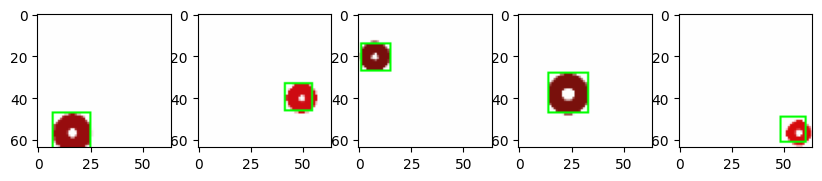

[[60 61 48 49]]


In [15]:
#проверка работы
def testing():
    for ii, cc in dataset.take(1):
        #обрабатывем целый батч, используем только пять элементов
        pred = model.nn_box(ii)
        plt.figure(figsize=(10, 6))
        
        for num in range(5):
            i = ii[num]
            
            pred = tf.reshape(pred, [-1, 1, 4])
            c = pred[num]

            ax = plt.subplot(1, 5, num+1)
            #переход в numpy для работы в opencv
            i = i.numpy()
            c = c.numpy()
            c = (c+1)/2*64 #обратно из от -1...1 к 0...64
            c = c.astype(np.int16)  #для opencv
            for bb in c:
                i = cv2.rectangle(i ,(bb[0] ,bb[1] ),(bb[2], bb[3]),(0,1,0),1)
            plt.imshow(i)
            
        plt.show()
        print(c)
        
testing()

50


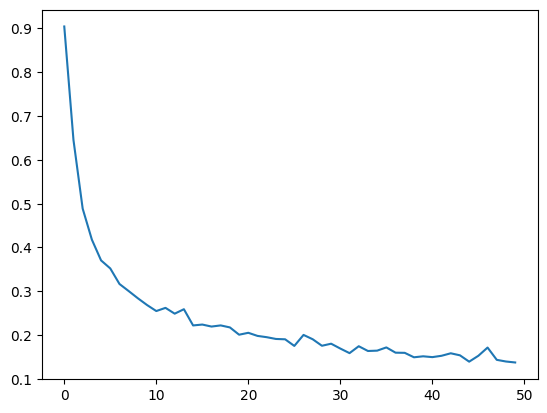

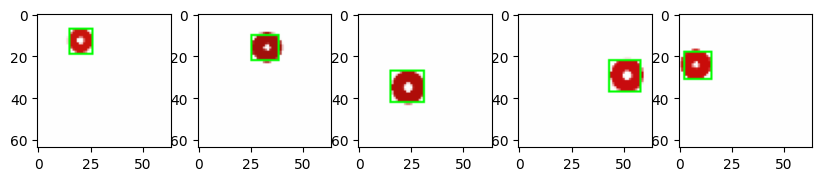

[[15 31  2 18]]


In [14]:
#обучение
from IPython.display import clear_output
hist = np.array(np.empty([0]))
epochs = 50
for epoch in range(1, epochs + 1):
    loss = 0
    lc = 0
    for step, (i, c) in enumerate(dataset):
        loss+=tf.reduce_mean(model.training_step(i,c))
        lc+=1
    clear_output(wait=True)
    print(epoch)
    hist = np.append(hist, loss/lc)
    plt.plot(np.arange(0,len(hist)), hist)
    plt.show()
    testing()

In [16]:
#сохранить
model.nn_box.save('bounding_box_for_one_object.h5')

In [17]:
#загрузить веса
model.nn_box.load_weights('bounding_box_for_one_object.h5')